# Generating interactive visualizations

---

Using the normative models fitted in chapter 6, we now turn our attention to generating exemplary interactive visualizations to better showcase the findings.


### package imports and basic functions

---

In [1]:
import os
import gc
import sys
import glob
import json
import random
import datetime
import importlib
import itertools
import numpy as np
from scipy import spatial
import scipy.sparse as sparse
import scipy.stats as stats
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from tqdm.notebook import tqdm
from sklearn import metrics


In [2]:
# pymc libraries
import pymc as pm
import arviz as az
import xarray as xr
import patsy

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v5.14.0


In [3]:
class MyNumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def ensure_dir(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    return file_name


def list_dirs(path=os.getcwd()):
    files = glob.glob(os.path.join(path, '*'))
    files = [x for x in files if os.path.isdir(x)]
    return files


def file_exists(file_name, path_name=os.getcwd()):
    return os.path.isfile(os.path.join(path_name, file_name))


def write_json(json_obj, file_path):
    with open(file_path, 'w') as outfile:
        json.dump(json_obj, outfile, sort_keys=True, indent=4,
                  cls=MyNumpyEncoder)
    return json_obj


def load_json(file_path):
    with open(file_path, 'r') as infile:
        return json.load(infile)


def write_np(np_obj, file_path):
    with open(file_path, 'wb') as outfile:
        np.save(outfile, np_obj)


def load_np(file_path):
    with open(file_path, 'rb') as infile:
        return np.load(infile)


In [8]:
# path setting
main_dir = os.path.abspath('../../..')
main_dir


'/mountpoint/code/projects/normative_brain_charts'

### Brain visualization functions

---

In [5]:
from nilearn import datasets, surface, plotting
from matplotlib.colors import LinearSegmentedColormap


In [6]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']


In [9]:
# basic parameters
surface = 'inflated_MSMAll'
expand = 0

# load an example dscalar
dscalar_file = f'{main_dir}/data/templates/ones.dscalar.nii'
dscalar = nib.load(dscalar_file)

brain_models = [x for x in dscalar.header.get_index_map(1).brain_models]

# load surfaces for visualization
left_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.L.{surface}.32k_fs_LR.surf.gii'
left_surface = nib.load(left_surface_file)
right_surface_file = f'{main_dir}/data/templates/hcp_surf/S1200.R.{surface}.32k_fs_LR.surf.gii'
right_surface = nib.load(right_surface_file)

# extract surface information
lx, ly, lz = left_surface.darrays[0].data.T
lt = left_surface.darrays[1].data
rx, ry, rz = right_surface.darrays[0].data.T
rt = right_surface.darrays[1].data

# combine into a complete brain
lrx = np.concatenate([lx - expand, rx + expand])
lry = np.concatenate([ly, ry])
lrz = np.concatenate([lz, rz])
lrt = np.concatenate([lt, (rt + lx.shape[0])])

lxyz = left_surface.darrays[0].data
rxyz = right_surface.darrays[0].data
lrxyz = np.array([lrx, lry, lrz]).T

# create a mapping between surface and cifti vertices
left_cortical_surface_model, right_cortical_surface_model = brain_models[0], brain_models[1]
cifti_to_surface = {}
surface_to_cifti = {}
for (i, x) in enumerate(left_cortical_surface_model.vertex_indices):
    cifti_to_surface[i] = x
    surface_to_cifti[x] = i
for (i, x) in enumerate(right_cortical_surface_model.vertex_indices):
    cifti_to_surface[i + right_cortical_surface_model.index_offset] = x + rx.shape[0]
    surface_to_cifti[x + rx.shape[0]] = i + right_cortical_surface_model.index_offset

# construct data over surface
surface_mask = list(surface_to_cifti.keys())


In [10]:
# arbitrary colormap
mycm = LinearSegmentedColormap.from_list(
    'my_gradient',
    (
        (0.0, (0.1, 0.1, 1.,)),
        # (0.4999, (0.9, 0.9, 1.,)),
        (0.25, (0.1, 1., 1.,)),
        # (0.4999, (0.9, 1., 1.,)),
        (0.5, (1., 1., 1.,)),
        # (0.5001, (1., 1., 0.9,)),
        (0.75, (1., 1., 0.1,)),
        # (0.5001, (1., 0.9, 0.9,)),
        (1.0, (1., 0.1, 0.1,)),
    )
)

mycm_dark = LinearSegmentedColormap.from_list(
    'my_gradient',
    (
        (0.0, (0.05, 1., 1.,)),
        (0.35, (0.05, 0.05, 1.,)),
        (0.5, (0.2, 0.05, 0.05,)),
        (0.65, (1., 0.05, 0.05,)),
        (1.0, (1., 1., 0.05,)),
    )
)

# ignore warning when loading cifti
nib.imageglobals.logger.setLevel(40)

# load sulcal depth for background
sulcal_depth = nib.load(f"{main_dir}/data/templates/hcp_surf/S1200.sulc_MSMAll.32k_fs_LR.dscalar.nii")


# visualization via nilearn
def plot_data_on_brain_surface(data, title="", cmap=mycm, symmetric_cbar=True, vmax=None, vmin=None, background_data=sulcal_depth.get_fdata()[0], darkness=0.1, auto_vlim_quantile=0.05, colorbar_format=None):
    """
    Plot a cifti-like data over the fs-LR32k surface space.
    ----------------------------------------------------------------
    Parameters:
        - data: a vector of shape (59412,) to be visualized.
        - title: the title of generated plot.
        - cmap: the colormap used for the plot.
        - symmetric_cbar: bool, Specifies whether the 
          colorbar should be symmetric (centered at zero).
        - vmax: colorbar max limit.
        - vmin: colorbar min limit.
        - background data: a surface data to project as a shadow
          behind the main data. (use None for no background)
        - darkness: the background effect
        - auto_vlim_quantile: the quantile to define vmin and vmax
          automatically (should be in the range of [0,0.5)]).
        - colorbar_format: string format for numbers in colorbar.
    ----------------------------------------------------------------
    """
    # Initialization
    if vmax is None:
        vmax = np.quantile(data,1 - auto_vlim_quantile)
    if vmin is None:
        vmin = np.quantile(data,auto_vlim_quantile)
    if symmetric_cbar:
        (vmin, vmax) = -max(abs(vmin), abs(vmax)), max(abs(vmin), abs(vmax))
    if background_data is not None:
        background = True
    else:
        background = False
    
    # surface center
    cxyz=(lrxyz.min(0) + lrxyz.max(0))/2

    # transfer data to surface scalar
    surface_scalars = np.empty(lrx.shape[0])
    surface_scalars[:] = np.nan
    surface_scalars[surface_mask] = data.copy()

    # decompose left and right information
    left_surface_scalars = surface_scalars[:lx.shape[0]]
    right_surface_scalars = surface_scalars[-rx.shape[0]:]
    
    # Generate background data
    surface_background_data = np.zeros(lrx.shape[0])
    surface_background_data[surface_mask] = background_data.copy()
    left_background_data = surface_background_data[:lx.shape[0]]
    right_background_data = surface_background_data[-rx.shape[0]:]


    fig, axes = plt.subplots(2, 2, figsize=(8, 8), subplot_kw={'projection': '3d'});

    zoom_coeff = 0.85

    # 'lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior'
    plotting.plot_surf(
        [lxyz-cxyz, lt],
        left_surface_scalars,
        axes=axes[0,0],
        view='lateral',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=left_background_data,
    );
    axes[0,0].set_xlim3d(np.array(axes[0,0].get_xlim3d())*zoom_coeff)
    axes[0,0].set_ylim3d(np.array(axes[0,0].get_ylim3d())*zoom_coeff)
    axes[0,0].set_zlim3d(np.array(axes[0,0].get_zlim3d())*zoom_coeff)

    plotting.plot_surf(
        [rxyz-cxyz, rt],
        right_surface_scalars,
        axes=axes[0,1],
        view='medial',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=right_background_data,
    );
    axes[0,1].set_xlim3d(np.array(axes[0,1].get_xlim3d())*zoom_coeff)
    axes[0,1].set_ylim3d(np.array(axes[0,1].get_ylim3d())*zoom_coeff)
    axes[0,1].set_zlim3d(np.array(axes[0,1].get_zlim3d())*zoom_coeff)


    plotting.plot_surf(
        [lxyz-cxyz, lt],
        left_surface_scalars,
        axes=axes[1,0],
        view='medial',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=left_background_data,
    );
    axes[1,0].set_xlim3d(np.array(axes[1,0].get_xlim3d())*zoom_coeff)
    axes[1,0].set_ylim3d(np.array(axes[1,0].get_ylim3d())*zoom_coeff)
    axes[1,0].set_zlim3d(np.array(axes[1,0].get_zlim3d())*zoom_coeff)

    plotting.plot_surf(
        [rxyz-cxyz, rt],
        right_surface_scalars,
        axes=axes[1,1],
        view='lateral',
        colorbar=False,
        symmetric_cbar=False,
        darkness=darkness,
        vmax=vmax,
        vmin=vmin,
        cmap=cmap,
        bg_on_data=background,
        bg_map=right_background_data,
    );
    axes[1,1].set_xlim3d(np.array(axes[1,1].get_xlim3d())*zoom_coeff)
    axes[1,1].set_ylim3d(np.array(axes[1,1].get_ylim3d())*zoom_coeff)
    axes[1,1].set_zlim3d(np.array(axes[1,1].get_zlim3d())*zoom_coeff)

    fig.suptitle(title, fontsize=24, y=0.98);
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=-0., hspace=-0.25)

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axins = inset_axes(
        axes[0,0],
        width="30%",
        height="4%",
        loc="center",
        bbox_to_anchor=(-0., 0.02, 1., 1.),
        bbox_transform=fig.transFigure,
        borderpad=0,
    )
    cb = fig.colorbar(
        mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax),
            cmap=cmap
        ),
        cax=axins,
        aspect=10,
        orientation='horizontal',
        format=colorbar_format,
    )
    cb.outline.set_visible(False)
    cb.ax.tick_params(labelsize=12)
    cb.ax.tick_params(length=0)


#### Faster brain visualization by Cerebro

---

In [11]:
# Cerebro brain viewer used for visualization
from cerebro import cerebro_brain_utils as cbu
from cerebro import cerebro_brain_viewer as cbv


In [12]:
# Brain visualizations with Cerebro

# ignore warning when loading cifti
nib.imageglobals.logger.setLevel(40)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec

def plot_single_view_with_cerebro(dscalar_data, ax, colormap=plt.cm.coolwarm, clims=None, vlims=None, exclusion_color=(1.,1.,1.,0), view="L", show_colorbar=False, colorbar_format=None, cifti_left_right_seperation=0, surface = 'midthickness'):
    try:
        
        my_brain_viewer = cbv.Cerebro_brain_viewer(offscreen=True, background_color=(1.,1.,1.,0), null_color=(1., 1., 1., 0.0), no_color=(0.7, 0.7, 0.7, 1.))

        surface_model = my_brain_viewer.load_template_GIFTI_cortical_surface_models(surface)

        cifti_space = my_brain_viewer.visualize_cifti_space(
            volumetric_structures='none', cifti_left_right_seperation=cifti_left_right_seperation,
        )

        dscalar_layer = my_brain_viewer.add_cifti_dscalar_layer(
            dscalar_data=dscalar_data,
            colormap=colormap,
            clims=clims,
            vlims=vlims,
            exclusion_color=exclusion_color,
            opacity=0.95)

        ax.axis('off')
        camconf = my_brain_viewer._view_to_camera_config(view)
        # camconf = my_brain_viewer.zoom_camera_to_content(camconf)
        my_brain_viewer.viewer.change_view(**camconf)
        my_brain_viewer.offscreen_draw_to_matplotlib_axes(ax)

    finally:
        my_brain_viewer.viewer.window.destroy()

def plot_left_right_surface_with_cerebro(dscalar_data, ax, colormap=plt.cm.coolwarm, clims=None, show_colorbar=False, colorbar_format=None, **kwargs):
    # Hide the parent axis
    ax.set_visible(False)

    # Create a 2x2 GridSpec within the axis using inset_axes
    gs = ax.inset_axes([0, 0, 1, 1], transform=ax.transAxes)
    sub_gs = GridSpec(2, 2, gs, hspace=0., wspace=0.)

    # Create a 4x4 grid
    ax_tl = fig.add_subplot(sub_gs[0, 0])
    ax_tr = fig.add_subplot(sub_gs[0, 1])
    ax_bl = fig.add_subplot(sub_gs[1, 0])
    ax_br = fig.add_subplot(sub_gs[1, 1])
    
    # separate data to left and right
    dscalar_data_left = dscalar_data.copy()
    dscalar_data_left[left_cortical_surface_model.index_count:] = np.nan
    dscalar_data_right = dscalar_data.copy()
    dscalar_data_right[:left_cortical_surface_model.index_count] = np.nan
    
    # Lateral left view
    plot_single_view_with_cerebro(dscalar_data_left, ax_tl, colormap=colormap, clims=clims,
                                  view=((-420, 0, 0), None, None, None), **kwargs)
    # Medial left view
    plot_single_view_with_cerebro(dscalar_data_left, ax_bl, colormap=colormap, clims=clims,
                                  view=((420, 0, 0), None, None, None), cifti_left_right_seperation=-80, **kwargs)
    
    # Lateral right view
    plot_single_view_with_cerebro(dscalar_data_right, ax_tr, colormap=colormap, clims=clims,
                                  view=((420, 0, 0), None, None, None), **kwargs)
    # Medial right view
    plot_single_view_with_cerebro(dscalar_data_right, ax_br, colormap=colormap, clims=clims,
                                  view=((-420, 0, 0), None, None, None), cifti_left_right_seperation=-80, **kwargs)

    if show_colorbar:
        cax = inset_axes(
            ax,
            width="30%",
            height="4%",
            loc="center",
            bbox_to_anchor=(-0., 0.0, 1., 1.),
            bbox_transform=ax.transAxes,
            borderpad=0,
        )
        cb = fig.colorbar(
            mpl.cm.ScalarMappable(
                norm=mpl.colors.Normalize(vmin=clims[0], vmax=clims[1]),
                cmap=colormap
            ),
            cax=cax,
            aspect=10,
            orientation='horizontal',
            format=colorbar_format,
        )
        cb.outline.set_visible(False)
        cb.ax.tick_params(labelsize=12)
        cb.ax.tick_params(length=0)


## Load the connectome kernel

---

In [13]:
# store the computed kernel
connectome_kernel_eigenvalues = load_np(f'{main_dir}/data/npy/rw_cortical_connectome_eigenvalues_cifti.npy');
connectome_kernel_eigenvectors = load_np(f'{main_dir}/data/npy/rw_cortical_connectome_eigenvectors_cifti.npy');


## Create a fixed BSpline function to ensure consistent nonlinear expansions of age across all models

---



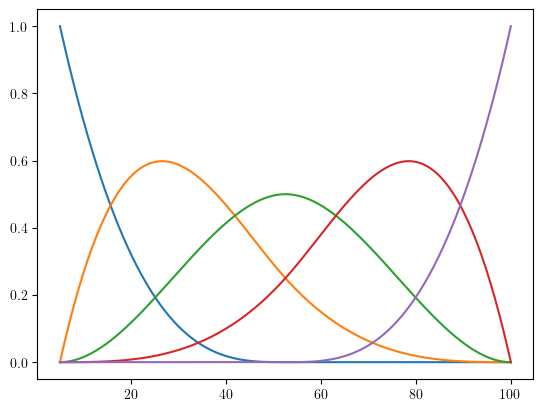

In [14]:
# fixed B-spline
age_min=5
age_max=100
num_knots = 3
patsy_knots = np.linspace(age_min, age_max, num_knots)[1:-1]
fixed_B_spline_age = patsy.dmatrix(
    "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
    {"xi": (np.linspace(age_min, age_max, 200)), "knots": patsy_knots},
)
plt.plot(np.linspace(age_min, age_max, 200), fixed_B_spline_age)



## Load selected covariance pairs

---

The largest pairs of kernels in terms of correlation are stored to model a sparse covariance structure.


In [15]:
corr_max_all = load_np(f'{main_dir}/data/models/pymc/connectome_rw_kernel_rho/corr_max_all.npy')
selected_pairs = load_np(f'{main_dir}/data/models/pymc/connectome_rw_kernel_rho/selected_pairs_rho.npy')


In [16]:
rows, cols = np.where(corr_max_all>0.25)
rows_lim = rows[rows < cols]
cols_lim = cols[rows < cols]


In [17]:
len(selected_pairs)

4261

In [18]:
len(rows_lim)

4261

In [19]:
%%time
sparse_filler = sparse.coo_matrix(
    (np.ones(selected_pairs.shape[0]), (selected_pairs[:, 0], selected_pairs[:, 1])),
    shape=(selected_pairs.max() + 1, selected_pairs.max() + 1)
)


CPU times: user 246 µs, sys: 400 µs, total: 646 µs
Wall time: 462 µs


## Load fitted kernel normative models

---


In [20]:
%%time
kernel_posteriors = xr.open_dataset(f'{main_dir}/data/models/pymc/combined_connectome_rw_kernel_posteriors_pymc_advi.nc')
kernel_posteriors


CPU times: user 101 ms, sys: 7.94 ms, total: 109 ms
Wall time: 2.37 s


<xarray.Dataset> Size: 5GB
Dimensions:                (chain: 1, draw: 2000, kernel: 10000, sex: 2,
                            site: 3, splines: 5)
Coordinates:
  * chain                  (chain) int64 8B 0
  * draw                   (draw) int64 16kB 0 1 2 3 4 ... 1996 1997 1998 1999
  * sex                    (sex) float64 16B 1.0 0.0
  * site                   (site) <U13 156B 'HCP-YA-site_0' ... 'HCP-A-site_0'
  * splines                (splines) int64 40B 0 1 2 3 4
Dimensions without coordinates: kernel
Data variables:
    mu_intercept_site      (kernel, chain, draw) float64 160MB ...
    intercept_sex          (kernel, chain, draw, sex) float64 320MB ...
    intercept_site_offset  (kernel, chain, draw, site) float64 480MB ...
    w_age                  (kernel, chain, draw, splines) float64 800MB ...
    sigma_intercept_site   (kernel, chain, draw) float64 160MB ...
    sigma_error_site       (kernel, chain, draw) float64 160MB ...
    w_error_age            (kernel, chain, draw, splines) float64 800MB ...
    error_sex              (kernel, chain, draw, sex) float64 320MB ...
    error_site_offset      (kernel, chain, draw, site) float64 480MB ...
    intercept_site         (kernel, chain, draw, site) float64 480MB ...
    error_site             (kernel, chain, draw, site) float64 480MB ...
Attributes:
    created_at:                 2023-12-29T07:54:18.553670
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.2.2

In [21]:
%%time
kernel_posterior_means = xr.open_dataset(f'{main_dir}/data/models/pymc/combined_connectome_rw_kernel_posterior_means_pymc_advi.nc',)
kernel_posterior_means


CPU times: user 31 ms, sys: 2.61 ms, total: 33.6 ms
Wall time: 128 ms


<xarray.Dataset> Size: 2MB
Dimensions:                (kernel: 10000, sex: 2, site: 3, splines: 5)
Coordinates:
  * sex                    (sex) float64 16B 1.0 0.0
  * site                   (site) <U13 156B 'HCP-YA-site_0' ... 'HCP-A-site_0'
  * splines                (splines) int64 40B 0 1 2 3 4
Dimensions without coordinates: kernel
Data variables:
    mu_intercept_site      (kernel) float64 80kB ...
    intercept_sex          (kernel, sex) float64 160kB ...
    intercept_site_offset  (kernel, site) float64 240kB ...
    w_age                  (kernel, splines) float64 400kB ...
    sigma_intercept_site   (kernel) float64 80kB ...
    sigma_error_site       (kernel) float64 80kB ...
    w_error_age            (kernel, splines) float64 400kB ...
    error_sex              (kernel, sex) float64 160kB ...
    error_site_offset      (kernel, site) float64 240kB ...
    intercept_site         (kernel, site) float64 240kB ...
    error_site             (kernel, site) float64 240kB ...

In [22]:
%%time
rho_kernel_posteriors = xr.open_dataset(f'{main_dir}/data/models/pymc/combined_connectome_rw_rho_kernel_posteriors_pymc_advi.nc')
rho_kernel_posteriors


CPU times: user 39.7 ms, sys: 1.12 ms, total: 40.8 ms
Wall time: 419 ms


<xarray.Dataset> Size: 1GB
Dimensions:                    (chain: 1, draw: 2000, kernel_pair: 4261,
                                sex: 2, site: 3, splines: 5)
Coordinates:
  * chain                      (chain) int64 8B 0
  * draw                       (draw) int64 16kB 0 1 2 3 ... 1996 1997 1998 1999
  * sex                        (sex) float64 16B 1.0 0.0
  * site                       (site) <U13 156B 'HCP-YA-site_0' ... 'HCP-A-si...
  * splines                    (splines) int64 40B 0 1 2 3 4
Dimensions without coordinates: kernel_pair
Data variables:
    mu_intercept_site_rho      (kernel_pair, chain, draw) float64 68MB ...
    intercept_sex_rho          (kernel_pair, chain, draw, sex) float64 136MB ...
    intercept_site_offset_rho  (kernel_pair, chain, draw, site) float64 205MB ...
    w_age_rho                  (kernel_pair, chain, draw, splines) float64 341MB ...
    sigma_intercept_site_rho   (kernel_pair, chain, draw) float64 68MB ...
    intercept_site_rho         (kernel_pair, chain, draw, site) float64 205MB ...
Attributes:
    created_at:                 2023-11-25T06:27:36.091019
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.2.2

In [23]:
%%time
rho_kernel_posterior_means = xr.open_dataset(f'{main_dir}/data/models/pymc/combined_connectome_rw_rho_kernel_posterior_means_pymc_advi.nc')
rho_kernel_posterior_means


CPU times: user 21.8 ms, sys: 2.92 ms, total: 24.7 ms
Wall time: 125 ms


<xarray.Dataset> Size: 512kB
Dimensions:                    (kernel_pair: 4261, sex: 2, site: 3, splines: 5)
Coordinates:
  * sex                        (sex) float64 16B 1.0 0.0
  * site                       (site) <U13 156B 'HCP-YA-site_0' ... 'HCP-A-si...
  * splines                    (splines) int64 40B 0 1 2 3 4
Dimensions without coordinates: kernel_pair
Data variables:
    mu_intercept_site_rho      (kernel_pair) float64 34kB ...
    intercept_sex_rho          (kernel_pair, sex) float64 68kB ...
    intercept_site_offset_rho  (kernel_pair, site) float64 102kB ...
    w_age_rho                  (kernel_pair, splines) float64 170kB ...
    sigma_intercept_site_rho   (kernel_pair) float64 34kB ...
    intercept_site_rho         (kernel_pair, site) float64 102kB ...

### Also Load observed training moments (mean and sigma used for standardization)

---


In [24]:
%%time
kernel_means = np.load(f'{main_dir}/data/models/pymc/connectome_rw_kernel/kernel_means.npy').tolist()
kernel_stds = np.load(f'{main_dir}/data/models/pymc/connectome_rw_kernel/kernel_stds.npy').tolist()


CPU times: user 1.25 ms, sys: 1.96 ms, total: 3.21 ms
Wall time: 81.7 ms


## Data preparations

---

Here we'll prepare the data that will be used in the visualizations


In [102]:
def unit(idx, shape):
    unit = np.zeros(shape)
    unit[idx] = 1
    return unit

In [103]:
%%time
from Connectome_Spatial_Smoothing import CSS as css

# Create two alternative smoothing kernels
# smoothing_kernel_4mmFWHM = css.compute_smoothing_kernel(left_surface_file, right_surface_file, fwhm=4, epsilon=0.01,)
smoothing_kernel_8mmFWHM = css.compute_smoothing_kernel(left_surface_file, right_surface_file, fwhm=8, epsilon=0.01,)


CPU times: user 1.8 s, sys: 566 ms, total: 2.37 s
Wall time: 2min 4s


In [108]:
sex_encoding = {
    "Male": 1, "Female": 0,
}

sigmoid = lambda x: 1/(1 + np.exp(-x))

def get_high_resolution_thickness_norm_at_age(age_of_interest, sex_of_interest=0, site_of_interest=2, n_kernel=1000):
    # fixed B-spline
    age_min=5
    age_max=100
    num_knots = 3
    patsy_knots = np.linspace(age_min, age_max, num_knots)[1:-1]
    # site_of_interest = 2 # HCP Aging

    prediction_B_spline_age = patsy.dmatrix(
        "bs(xi, knots=knots, degree=3, include_intercept=True) - 1",
        {
            "xi": xr.DataArray([age_min, age_of_interest, age_max], dims=["obs_id"]),
            "knots": patsy_knots
        }
    )[1]
    
    # reduce to a particular number of kernels
    kernel_posterior_means_subset = kernel_posterior_means.isel(kernel=range(n_kernel))

    kernels_y_ppc_mu_mean = (
        kernel_posterior_means_subset['intercept_sex'].isel(sex=sex_of_interest) +
        kernel_posterior_means_subset['intercept_site'].isel(site=site_of_interest) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["splines"]),
            kernel_posterior_means_subset['w_age']
        )
    ) * xr.DataArray(kernel_stds[:n_kernel], dims=["kernel"]) + xr.DataArray(kernel_means[:n_kernel], dims=["kernel"])
    
    feature_encoding = smoothing_kernel_8mmFWHM.T.dot(connectome_kernel_eigenvectors[:, :n_kernel])

    # high_resolution_mean_thickness_of_interest = np.array(kernels_y_ppc_mu_mean).dot(connectome_kernel_eigenvectors[:,:n_kernel].T)
    high_resolution_mean_thickness_of_interest = np.array(kernels_y_ppc_mu_mean).dot(feature_encoding.T)
    
    rho_ppc_mean = 2 * sigmoid(
        rho_kernel_posterior_means['intercept_sex_rho'].isel(sex=sex_of_interest).data +
        rho_kernel_posterior_means['intercept_site_rho'].isel(site=site_of_interest).data +
        xr.DataArray(np.asarray(prediction_B_spline_age), dims=["splines"]).dot(
            rho_kernel_posterior_means['w_age_rho']
        ).data
    ) - 1

    kernels_y_ppc_sigma_mean = (
        kernel_posterior_means_subset['error_sex'].isel(sex=sex_of_interest) +
        kernel_posterior_means_subset['error_site'].isel(site=site_of_interest) +
        xr.dot(
            xr.DataArray(np.asarray(prediction_B_spline_age), dims=["splines"]),
            kernel_posterior_means_subset['w_error_age']
        )
    ) * xr.DataArray(kernel_stds[:n_kernel], dims=["kernel"])

    sparse_correlations = sparse_filler.copy()
    sparse_correlations.data = rho_ppc_mean
    sparse_correlations = (sparse_correlations + sparse_correlations.T)
    sparse_correlations.setdiag(1)
    sparse_correlations = sparse_correlations.tocsr()[:n_kernel, :n_kernel]
    
    encoded_y_ppc_sigma_mean = np.multiply(feature_encoding, np.array(kernels_y_ppc_sigma_mean))

    high_resolution_std_thickness_of_interest = np.power(
        np.multiply(
            encoded_y_ppc_sigma_mean,
            sparse_correlations.dot(encoded_y_ppc_sigma_mean.T).T,
        ).sum(1),
        0.5
    )
    
    return high_resolution_mean_thickness_of_interest, high_resolution_std_thickness_of_interest



In [109]:
mean_estimates = {}
std_estimates = {}

for age in tqdm(range(5, 96, 1)):
    for sex in ["Male", "Female"]:
        mean_estimates[(age, sex)], std_estimates[(age, sex)] = get_high_resolution_thickness_norm_at_age(age_of_interest=age, sex_of_interest=sex_encoding[sex])


  0%|          | 0/91 [00:00<?, ?it/s]

## Interactive visualizations

---

Here we'll write the functions to generate the visualizations


In [ ]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import trimesh

def vertex_intensities(intensity_map):
    placeholder = np.zeros(lrxyz.shape[0]) * np.nan
    placeholder[surface_mask] = intensity_map
    return placeholder

def get_rgba(hex_color, alpha=0.3):
    # Convert hex color to RGB
    r = int(hex_color[1:3], 16)
    g = int(hex_color[3:5], 16)
    b = int(hex_color[5:7], 16)
    # Combine into rgba format
    return f'rgba({r}, {g}, {b}, {alpha})'

# Initial values
default_age = 50
default_sex = "Male"
default_intensity = vertex_intensities(mean_estimates[(default_age, default_sex)])
default_customdata = vertex_intensities(std_estimates[(default_age, default_sex)])
# default_customdata = vertex_intensities(np.arange(59412))

# Fixed clim
cmin_global = 1.5
cmax_global = 4.5

# Create subplot layout: 1 row, 2 columns
fig = make_subplots(
    rows=2, cols=1, vertical_spacing=0.01, row_heights=[1, 0.4],
    # subplot_titles=("3D Brain view", "2D Plot (Vertex Selection)"),
    specs=[[{"type": "surface"}], [{"type": "xy"}]]
)

# Add 3D surface plot in left panel (to be updated later)
surface = go.Mesh3d(
    x=lrxyz[:, 0],
    y=lrxyz[:, 1],
    z=lrxyz[:, 2],
    i=lrt[:, 0],
    j=lrt[:, 1],
    k=lrt[:, 2],
    intensity=default_intensity,
    customdata=default_customdata,
    colorscale="ylorrd",
    showscale=True,
    colorbar=dict(
        x=-0.1,  # Move left/right
        y=0.65,  # Move up/down
        len=0.4,  # Adjust height (0 to 1)
        thickness=20,  # Adjust width (pixels)
        title=dict(
            text="mm",  # Colorbar label text
            side="top",  # Place vertically on the left side
            font=dict(size=14, color="black"),  # Customize font
        ),
        tickfont=dict(size=12, color="black"),  # Customize tick labels
        outlinewidth=1,  # Outline thickness
        outlinecolor="black",  # Outline color
    ),
    hovertemplate='Thickness: %{intensity:.2f} ± %{customdata:.2f}mm<extra></extra>',
    flatshading=False,
    cmin=cmin_global,
    cmax=cmax_global,
)
fig.add_trace(surface, row=1, col=1)

# Add 3 spheres for arbitrary selected vertices
vertex_selections = [8666, 27343, 21733]
vertex_descriptions = ["Insular vertex", "Prefrontal vertex", "Occipital vertex"]
# Option 1: with plotly scatter, doesn't look nice
# spheres = go.Scatter3d(
#     x=[lrxyz[surface_mask[v], 0] for v in vertex_selections],
#     y=[lrxyz[surface_mask[v], 1] for v in vertex_selections],
#     z=[lrxyz[surface_mask[v], 2] for v in vertex_selections],
#     mode='markers',
#     marker=dict(size=10, color=px.colors.qualitative.Plotly[:len(vertex_selections)], opacity=1.),
#     name="Spheres"
# )
# fig.add_trace(spheres, row=1, col=1)
# Option 2: specify the meshes
base_sphere_mesh = trimesh.creation.icosphere(subdivisions=2, radius=2.0)
spheres = []
mycolors = [px.colors.qualitative.Plotly[i] for i in [0, 1, 2]]
for i, v in enumerate(vertex_selections):
    sphere = go.Mesh3d(
        x=base_sphere_mesh.vertices[:, 0] + lrxyz[surface_mask[v], 0],
        y=base_sphere_mesh.vertices[:, 1] + lrxyz[surface_mask[v], 1],
        z=base_sphere_mesh.vertices[:, 2] + lrxyz[surface_mask[v], 2],
        i=base_sphere_mesh.faces[:, 0],
        j=base_sphere_mesh.faces[:, 1],
        k=base_sphere_mesh.faces[:, 2],
        hovertemplate=f'{vertex_descriptions[i]}<extra></extra>',
        flatshading=False,
        color=mycolors[i],
        colorscale=[[0, mycolors[i]], [1, mycolors[i]]],
        showscale=False,
    )
    fig.add_trace(sphere, row=1, col=1)
    spheres.append(sphere)

# Add an empty 2D line plot (to be updated later)
age_range = list(range(5, 91, 1))
for i, v in enumerate(vertex_selections):
    means = [mean_estimates[(age, default_sex)][v] for age in age_range]
    uppers = [mean_estimates[(age, default_sex)][v] + std_estimates[(age, default_sex)][v] for age in age_range]
    lowers = [mean_estimates[(age, default_sex)][v] - std_estimates[(age, default_sex)][v] for age in age_range]
    fill_plot = go.Scatter(
        x=np.concatenate([age_range, age_range[::-1]]),
        y=np.concatenate([uppers, lowers[::-1]]),
        mode="lines", name="", fill='toself', showlegend=False,
        line=dict(color='rgba(255, 255, 255, 0)'),
        fillcolor=get_rgba(mycolors[i], alpha=0.2),
    )
    fig.add_trace(fill_plot, row=2, col=1)
for i, v in enumerate(vertex_selections):
    means = [mean_estimates[(age, default_sex)][v] for age in age_range]
    line_plot = go.Scatter(
        x=age_range,
        y=[mean_estimates[(age, default_sex)][v] for age in age_range],
        mode="lines", name=f"{vertex_descriptions[i]}",
        line=dict(color=mycolors[i], width=4),
        hoverinfo='text',
        text=[f"Age: {age}, Thickness: {mean_estimates[(age, default_sex)][v]:.2f} ± {std_estimates[(age, default_sex)][v]:.2f}mm" for age in age_range]
    )
    fig.add_trace(line_plot, row=2, col=1)

# Update layout with title, sliders, and dropdown menu
fig.update_layout(
    title={
        'text': "High-resolution Thickness Charts via Spectral Normative Modeling",  # Title text
        'x': 0.5,  # Centered (0 = left, 1 = right)
        'y': 0.98,  # Adjust vertical position
        'xanchor': 'center',  # Anchor at the center
        'yanchor': 'top',  # Align title to the top
        'font': {
            'size': 24,  # Title font size
            'color': 'black',  # Title font color
            'family': 'Arial, sans-serif',  # Font family
            'weight': 'bold', # Bold text
        }
    },
    width=800,
    height=1000,
    scene1=dict(
        xaxis=dict(title='X', visible=False),
        yaxis=dict(title='Y', visible=False),
        zaxis=dict(title='Z', visible=False),
        camera_eye=dict(x=-1.3, y=0., z=0.)
    ),
    plot_bgcolor="white",
    margin=dict(l=40., r=40., b=40., t=160.),
    sliders=[
        {
            "font": {"size": 18},
            "x": 0.5, "xanchor": "center",
            "y": 1.01, "yanchor": "bottom",
            "active": (default_age - 5)/5,  # Default position
            "currentvalue": {"prefix": "Age: ", "font": {"size": 18}},
            "pad": {"t": 50},
            "steps": [
                {
                    "label": str(age),
                    "method": "restyle",
                    "args": [{
                        "intensity": [vertex_intensities(mean_estimates[(age, default_sex)])],
                        "customdata": [vertex_intensities(std_estimates[(age, default_sex)])],
                    }],
                }
                for age in range(5, 91, 5)
            ]
        }
    ],
    legend=dict(
        x=0.98,  # Position the legend along the x-axis for the first subplot
        y=0.27,  # Position the legend along the y-axis for the first subplot
        xanchor='right',
        yanchor='top',
        # This hides the legend for the second subplot
        traceorder='normal'
    ),
)
fig.update_xaxes(
    title_text="Age",
    title_font=dict(size=16),
    tickfont=dict(size=14),
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    row=2, col=1,
)
fig.update_yaxes(
    title_text="Thickness (mm)",
    title_font=dict(size=16),
    tickfont=dict(size=14),
    title_standoff=1,
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    row=2, col=1,
)

fig.write_html(
    "/mountpoint/code/projects/normative_brain_charts/code/notebooks/08_interactive_visualization/08_01_interactive_visualization.html",
    include_plotlyjs="cdn", config={"displaylogo": False}
)

# Show figure
# fig.show(config= {'displaylogo': False})


In [236]:
1

1